In [2]:
# imports
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.calibration import CalibratedClassifierCV

In [7]:
# Load data
data = pd.read_csv('data_standardized2.csv')
data = data.drop(["Unnamed: 0"],axis=1)

# only keep best predictive features for linear svf; helps with time and overfitting
df = data[['age','bmi','weight','sbp','dbp','alt','chol','diabetes']]

# retrieve array
dataset = df.values

# split into input and output
X = dataset[:, :-1]
y = dataset[:,-1]

# dictionaries
models = dict()
hyperparameters = dict()

# split into test and train sets stratify on diabetes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=data['diabetes'],random_state=1)

# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (136789, 7) (136789,)
Test (67375, 7) (67375,)


In [5]:
# linear SVC with selected features only
# Train model linear SVC model 
lsvc_sf = LinearSVC(class_weight='balanced',max_iter=10000).fit(X_train, y_train)

# run 5m 40.5s

c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(lsvc_sf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

# run 95m 58.1s

Mean ROC AUC: 0.839


In [8]:
# Grid Search for Tuned Hyper Parameters

# Define parameters we want to tune
penalty = ['l1','l2']
fit_intercept = [True, False]
C = range(1, 10, 100)

# convert to dict
hyperparameters['penalty'] = penalty
hyperparameters['fit_intercept'] = fit_intercept
hyperparameters['C'] = C

#create new linearSVC object
lsvc_opt = LinearSVC(class_weight = 'balanced', max_iter=10000,random_state=1)


# Use gridsearch to find ideal hyperparameters
grid_search_lscv = GridSearchCV(lsvc_opt, 
                                hyperparameters, 
                                cv=2, # ditched evaluation procedure because of time, just using cv=2
                                verbose=5) 

# Fit the model
grid_search_lscv.fit(X_train, y_train)

# Add models to dictionary
models['Linear SVC (Grid Search Tuned)'] = grid_search_lscv

# run 15m 15.9s

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END .C=1, fit_intercept=True, penalty=l1;, score=nan total time=   0.2s
[CV 2/2] END .C=1, fit_intercept=True, penalty=l1;, score=nan total time=   0.1s


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/2] END C=1, fit_intercept=True, penalty=l2;, score=0.736 total time= 2.6min


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/2] END C=1, fit_intercept=True, penalty=l2;, score=0.741 total time= 2.2min
[CV 1/2] END C=1, fit_intercept=False, penalty=l1;, score=nan total time=   0.1s
[CV 2/2] END C=1, fit_intercept=False, penalty=l1;, score=nan total time=   0.1s


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/2] END C=1, fit_intercept=False, penalty=l2;, score=0.551 total time= 1.8min


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in

[CV 2/2] END C=1, fit_intercept=False, penalty=l2;, score=0.552 total time= 1.4min


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [9]:
# Get best parameters
print(models['Linear SVC (Grid Search Tuned)'].best_params_)
print(models['Linear SVC (Grid Search Tuned)'].best_estimator_)

grid_predictions = (models['Linear SVC (Grid Search Tuned)'].predict(X_test))
# print classification report
print(classification_report(y_test, grid_predictions))

{'C': 1, 'fit_intercept': True, 'penalty': 'l2'}
LinearSVC(C=1, class_weight='balanced', max_iter=10000, random_state=1)
              precision    recall  f1-score   support

          no       0.99      0.73      0.84     66103
         yes       0.06      0.81      0.10      1272

    accuracy                           0.74     67375
   macro avg       0.52      0.77      0.47     67375
weighted avg       0.98      0.74      0.83     67375



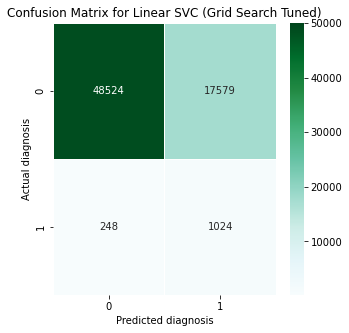

In [10]:
# Confusion matrix for LinearSVC model
lsvc_cm = confusion_matrix(y_test, grid_predictions)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(lsvc_cm, 
            annot = True,
            linewidths=0.5,
            fmt = ".0f",
            ax=ax,
            vmin=200,
            vmax=50000,
            cmap="BuGn"
)
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Linear SVC (Grid Search Tuned)')
plt.show()

In [34]:
# Grid Search for Tuned Hyper Parameters on SVC with linear kernal

# Define parameters we want to tune
C = range(1, 10, 100)
kernel = ['linear','poly','rbf','sigmoid']
degree = range(1, 10, 100)
gamma = ['scale','auto']

# convert to dict
hyperparameters = dict()
hyperparameters['C'] = C
hyperparameters['kernel'] = kernel
hyperparameters['degree'] = degree
hyperparameters['gamma'] = gamma

# create new SVC model
svc_opt = SVC(class_weight='balanced',  # adjusts weight according to values of y 
            probability=True            # this is the part that slows it down but allows for predict_proba
            )


# Use gridsearch to find ideal hyperparameters
grid_search_scv = GridSearchCV(svc_opt, hyperparameters, cv=2, verbose=5)

# Fit the model
grid_search_scv.fit(X_train, y_train)

# Add models to dictionary
models['SVC with Linear Kernal (Grid Search Tuned'] = grid_search_scv

# run 15m 15.9s

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END C=1, degree=1, gamma=scale, kernel=linear;, score=0.720 total time=15.0min
[CV 2/2] END C=1, degree=1, gamma=scale, kernel=linear;, score=0.724 total time=18.6min
[CV 1/2] END C=1, degree=1, gamma=scale, kernel=poly;, score=0.720 total time=17.9min
[CV 2/2] END C=1, degree=1, gamma=scale, kernel=poly;, score=0.724 total time=15.7min
[CV 1/2] END C=1, degree=1, gamma=scale, kernel=rbf;, score=0.735 total time=22.8min
[CV 2/2] END C=1, degree=1, gamma=scale, kernel=rbf;, score=0.747 total time=21.9min
[CV 1/2] END C=1, degree=1, gamma=scale, kernel=sigmoid;, score=0.655 total time=12.9min
[CV 2/2] END C=1, degree=1, gamma=scale, kernel=sigmoid;, score=0.636 total time=11.8min
[CV 1/2] END C=1, degree=1, gamma=auto, kernel=linear;, score=0.720 total time=16.0min
[CV 2/2] END C=1, degree=1, gamma=auto, kernel=linear;, score=0.724 total time=20.1min
[CV 1/2] END C=1, degree=1, gamma=auto, kernel=poly;, score=0.720 tota

{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=1, class_weight='balanced', degree=1, probability=True)
              precision    recall  f1-score   support

          no       0.99      0.73      0.84     66103
         yes       0.05      0.80      0.10      1272

    accuracy                           0.73     67375
   macro avg       0.52      0.76      0.47     67375
weighted avg       0.98      0.73      0.83     67375



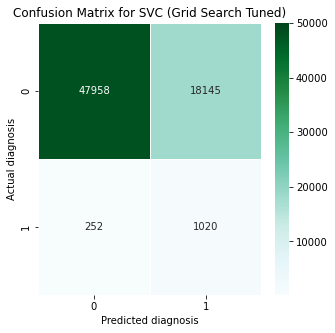

In [49]:
# Get best parameters
print(models['SVC with Linear Kernal (Grid Search Tuned'].best_params_)
print(models['SVC with Linear Kernal (Grid Search Tuned'].best_estimator_)

grid_predictions = (models['SVC with Linear Kernal (Grid Search Tuned'].predict(X_test))
# print classification report
print(classification_report(y_test, grid_predictions))

# Confusion matrix for SVC model
svc_cm = confusion_matrix(y_test, grid_predictions)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(svc_cm, 
            annot = True,
            linewidths=0.5, fmt = ".0f",
            ax=ax,
            vmin=200,
            vmax=50000, cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for SVC (Grid Search Tuned)')
plt.show()

In [ ]:
# tuned models are getting relatively the same values, largest benefit is the reduced run time
# another for logistic regression as a comparison?